In [1]:
import sys
import climin
from functools import partial
import warnings
import os
sys.path.append('..')

import numpy as np
from scipy.stats import multinomial
from scipy.linalg.blas import dtrmm

import GPy
from GPy.util import choleskies
from GPy.core.parameterization.param import Param
from GPy.kern import Coregionalize
from GPy.likelihoods import Likelihood
from GPy.util import linalg

from likelihoods.bernoulli import Bernoulli
from likelihoods.gaussian import Gaussian
from likelihoods.categorical import Categorical
from likelihoods.hetgaussian import HetGaussian
from likelihoods.beta import Beta
from likelihoods.gamma import Gamma
from likelihoods.exponential import Exponential

from hetmogp.util import draw_mini_slices
from hetmogp.het_likelihood import HetLikelihood
from hetmogp.svmogp import SVMOGP
from hetmogp import util
from hetmogp.util import vem_algorithm as VEM

import matplotlib.pyplot as plt
from matplotlib.pyplot import gca
from matplotlib import rc, font_manager
from matplotlib import rcParams
from matplotlib2tikz import save as tikz_save

warnings.filterwarnings("ignore")
os.environ['PATH'] = os.environ['PATH'] + ':/usr/texbin'

In [2]:
M = 20  # number of inducing points
Q = 3  # number of latent functions

# Heterogeneous Likelihood Definition
likelihoods_list = [Gaussian(sigma=1.), Bernoulli()] # Real + Binary
likelihood = HetLikelihood(likelihoods_list)
Y_metadata = likelihood.generate_metadata()
D = likelihood.num_output_functions(Y_metadata)

W_list, _ = util.random_W_kappas(Q, D, rank=1, experiment=True)

X1 = np.sort(np.random.rand(600))[:, None]
X2 = np.sort(np.random.rand(500))[:, None]
X = [X1, X2]

In [3]:
# True U and F functions
def experiment_true_u_functions(X_list):
    u_functions = []
    for X in X_list:
        u_task = np.empty((X.shape[0],2))
        u_task[:,0,None] = 4.5*np.cos(2*np.pi*X + 1.5*np.pi) - \
                           3*np.sin(4.3*np.pi*X + 0.3*np.pi) + \
                           5*np.cos(7*np.pi * X + 2.4*np.pi)
                
        u_task[:,1,None] = 4.5*np.cos(1.5*np.pi*X + 0.5*np.pi) + \
                   5*np.sin(3*np.pi*X + 1.5*np.pi) - \
                   5.5*np.cos(8*np.pi * X + 0.25*np.pi)

        u_functions.append(u_task)
    return u_functions


def experiment_true_f_functions(true_u, X_list):
    true_f = []
    W = W_lincombination()
    
    # D=1
    for d in range(2):
        f_d = np.zeros((X_list[d].shape[0], 1))
        for q in range(2):
            f_d += W[q][d].T*true_u[d][:,q,None]
        true_f.append(f_d)

    return true_f

# True Combinations
def W_lincombination():
    W_list = []
    # q=1
    Wq1 = np.array(([[-0.5],[0.1]]))
    W_list.append(Wq1)
    # q=2
    Wq2 = np.array(([[-0.1],[.6]]))
    W_list.append(Wq2)
    return W_list

In [4]:
# True functions values for inputs X
trueU = experiment_true_u_functions(X)
trueF = experiment_true_f_functions(trueU, X)

# Generating training data Y (sampling from heterogeneous likelihood)
Y = likelihood.samples(F=trueF, Y_metadata=Y_metadata) 

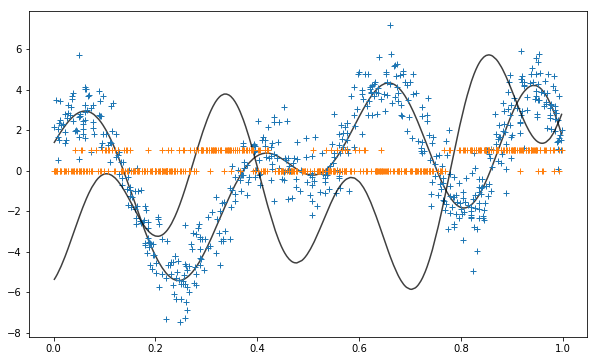

In [5]:
# Plot true parameter functions PFs (black) and heterogeneous data (blue, orange)
plt.figure(figsize=(10, 6))
Ntask = 2
for t in range(Ntask):
    plt.plot(X[t],trueF[t],'k-', alpha=0.75)
    plt.plot(X[t],Y[t],'+')
    
plt.show()

In [6]:
# Generating missing data (gap)
X2test = X[1][np.r_[351:450],:]
Y2test = Y[1][np.r_[351:450],:]

X2train_s1 = X[1][1:351,:]
X2train_s2 = X[1][450:,:]

X2 = np.delete(X2, np.s_[np.r_[351:450]],0)
Y2 = np.delete(Y[1], np.s_[np.r_[351:450]],0)


X = [X1, X2]
Y = [Y[0], Y2]

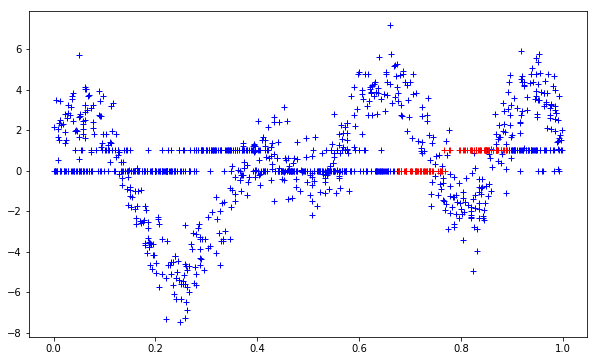

In [7]:
# Plot gap
plt.figure(figsize=(10, 6))
Ntask = 2
for t in range(Ntask):
    plt.plot(X[t],Y[t],'b+')
    
plt.plot(X2test, Y2test,'r+')
plt.show()
    

In [8]:
# KERNELS
ls_q = np.array(([.05]*Q))
var_q = np.array(([.5]*Q))
kern_list = util.latent_functions_prior(Q, lenghtscale=ls_q, variance=var_q, input_dim=1)

# # INDUCING POINTS
Z = np.linspace(0, 1, M)
Z = Z[:, np.newaxis]

In [9]:
# MODEL and INFERENCE
model = SVMOGP(X=X, Y=Y, Z=Z, kern_list=kern_list, likelihood=likelihood, Y_metadata=Y_metadata)
model = VEM(model, stochastic=False, vem_iters=3, optZ=True, verbose=False, verbose_plot=False, non_chained=False)

iteration (1) VE step, log_likelihood=[-1361.56143766]
iteration (1) VM step, log_likelihood=[-1264.31300804]
iteration (2) VE step, log_likelihood=[-1216.26087844]
iteration (2) VM step, log_likelihood=[-1207.59358878]
iteration (3) VE step, log_likelihood=[-1204.95658325]
iteration (3) VM step, log_likelihood=[-1201.61607532]


In [10]:
def plot_figure_gaplatex(model, Xtrain, Ytrain, Xtest, Ytest):
    sorted_Xtrain0 = np.sort(Xtrain[0])
    m_f_gaussian, v_f_gaussian = model._raw_predict_f(sorted_Xtrain0, output_function_ind=0)
    m_f_gaussian_upper = m_f_gaussian + 2*np.sqrt(v_f_gaussian)
    m_f_gaussian_lower = m_f_gaussian - 2*np.sqrt(v_f_gaussian)
    
    sorted_Xtrain1_s1 = np.sort(X2train_s1)
    m_f_ber, v_f_ber = model._raw_predict_f(sorted_Xtrain1_s1, output_function_ind=1)
    m_f_gp_upper = m_f_ber + 2*np.sqrt(v_f_ber)
    m_f_gp_lower = m_f_ber - 2*np.sqrt(v_f_ber)
    m_ber_gp_s1 = np.exp(m_f_ber)/ (1 + np.exp(m_f_ber))
    m_ber_gp_upper_s1 = np.exp(m_f_gp_upper)/ (1 + np.exp(m_f_gp_upper))
    m_ber_gp_lower_s1 = np.exp(m_f_gp_lower)/ (1 + np.exp(m_f_gp_lower))
    
    sorted_Xtrain1_s2 = np.sort(X2train_s2)
    m_f_ber, v_f_ber = model._raw_predict_f(sorted_Xtrain1_s2, output_function_ind=1)
    m_f_gp_upper = m_f_ber + 2*np.sqrt(v_f_ber)
    m_f_gp_lower = m_f_ber - 2*np.sqrt(v_f_ber)
    m_ber_gp_s2 = np.exp(m_f_ber)/ (1 + np.exp(m_f_ber))
    m_ber_gp_upper_s2 = np.exp(m_f_gp_upper)/ (1 + np.exp(m_f_gp_upper))
    m_ber_gp_lower_s2 = np.exp(m_f_gp_lower)/ (1 + np.exp(m_f_gp_lower))
    
    sorted_Xtest = np.sort(Xtest)
    m_pred_ber, v_pred_ber =model._raw_predict_f(sorted_Xtest, output_function_ind=1)
    m_pred_gp_upper = m_pred_ber + 2*np.sqrt(v_pred_ber)
    m_pred_gp_lower = m_pred_ber - 2*np.sqrt(v_pred_ber)
    m_pred_gp = np.exp(m_pred_ber)/ (1 + np.exp(m_pred_ber))
    m_pred_gp_upper = np.exp(m_pred_gp_upper)/ (1 + np.exp(m_pred_gp_upper))
    m_pred_gp_lower = np.exp(m_pred_gp_lower)/ (1 + np.exp(m_pred_gp_lower))
    
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    
    fig_gap_gaussian = plt.figure(figsize=(10, 5))
    plt.plot(Xtrain[0], Ytrain[0], 'x', color='blue', markersize=10, alpha=0.1)
    plt.plot(sorted_Xtrain0, m_f_gaussian, 'b-', linewidth=4, alpha=1)
    plt.plot(sorted_Xtrain0, m_f_gaussian_upper, 'b-', linewidth=4, alpha=0.25)
    plt.plot(sorted_Xtrain0, m_f_gaussian_lower, 'b-', linewidth=4, alpha=0.25)
    plt.title(r'Output 1: Gaussian Regression')
    plt.ylabel(r'Real Output')
    plt.xlabel(r'Real Input')
    plt.xlim(0,1)
    plt.show()
    
    fig_gap_bernoulli = plt.figure(figsize=(10, 5))
    plt.plot(X2, Y2, 'x', color='blue', markersize=10, alpha=0.1)
    plt.plot(Xtest, Ytest, 'x', color='red', markersize=10, alpha=0.1)
    
    plt.plot(sorted_Xtrain1_s1, m_ber_gp_s1, 'b-', linewidth=4, alpha=1)
    plt.plot(sorted_Xtrain1_s1, m_ber_gp_upper_s1, 'b-', linewidth=4, alpha=0.25)
    plt.plot(sorted_Xtrain1_s1, m_ber_gp_lower_s1, 'b-', linewidth=4, alpha=0.25)
    
    plt.plot(sorted_Xtrain1_s2, m_ber_gp_s2, 'b-', linewidth=4, alpha=1)
    plt.plot(sorted_Xtrain1_s2, m_ber_gp_upper_s2, 'b-', linewidth=4, alpha=0.25)
    plt.plot(sorted_Xtrain1_s2, m_ber_gp_lower_s2, 'b-', linewidth=4, alpha=0.25)
    
    plt.plot(sorted_Xtest, m_pred_gp, 'r-', linewidth=4, alpha=1)
    plt.plot(sorted_Xtest, m_pred_gp_upper, 'r-', linewidth=4, alpha=0.25)
    plt.plot(sorted_Xtest, m_pred_gp_lower, 'r-', linewidth=4, alpha=0.25)
    
    plt.title(r'Output 2: Binary Classification')
    plt.ylabel(r'Binary Output')
    plt.xlabel(r'Real Input')
    plt.xlim(0,1)
    plt.show()
    

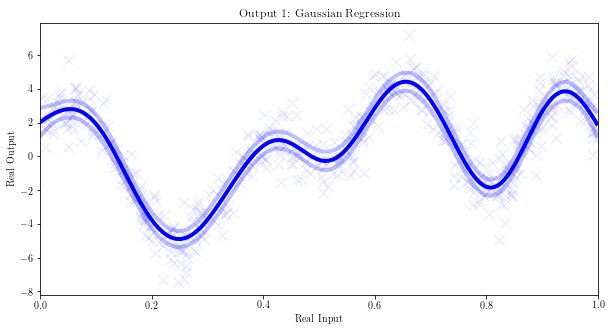

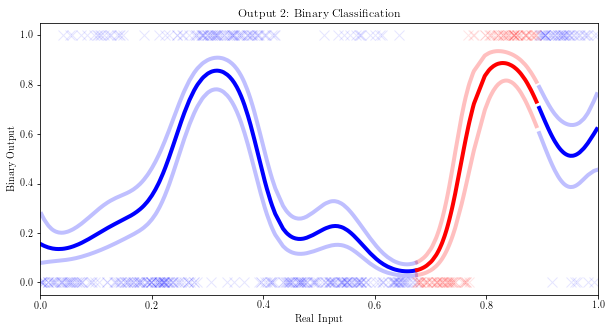

In [12]:
plot_figure_gaplatex(model, X, Y, X2test, Y2test)